In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
import time
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import random
import time
%matplotlib inline

In [2]:
random.seed(1438642)
df = pd.read_csv("train.csv")
patient_number = pd.read_csv("actual.csv")
patient_number.columns = ["index","cancer_type"]
test = pd.read_csv("test.csv")

In [3]:
columns_names = [col for col in df.columns if "call" not in col]
df1 = df[columns_names]
df2 = df1.drop(["Gene Description","Gene Accession Number"],axis=1)
df2  = df2.T

df2 = df2.reset_index()
df2["index"] = pd.to_numeric(df2["index"])
df2 = df2.sort_values("index")

df2  = pd.merge(df2, patient_number, on='index', how='inner')
df2.loc[df2.cancer_type=="ALL","cancer_type"] = 0
df2.loc[df2.cancer_type=="AML","cancer_type"] = 1
df2 = df2.sample(frac=1).drop(["index"],axis=1)

In [4]:
df2.head()

,0,1,2,3,4,5,6,7,8,9,...,7120,7121,7122,7123,7124,7125,7126,7127,7128,cancer_type
5,-138,-85,215,71,-272,-558,67,-186,87,193,...,1221,-76,172,-74,645,341,26,193,-53,0
28,15,-114,2,193,-51,-155,29,-105,42,524,...,492,54,277,-13,279,51,6,2484,-2,1
27,-4,-116,-125,241,-191,-411,-31,-240,150,24,...,755,-23,573,42,987,279,22,662,-46,1
15,-117,-219,-50,257,-218,-402,228,-147,65,67,...,631,-26,455,-62,736,445,42,246,-43,0
21,-247,-90,-168,-24,-308,-571,-170,-224,124,-117,...,402,57,253,-52,1010,405,19,270,-27,0


In [5]:
columns_names_test = [col for col in test.columns if "call" not in col]
test1 = test[columns_names_test]
test2 = test1.drop(["Gene Description","Gene Accession Number"],axis=1)
test2  = test2.T
test2 = test2.reset_index()
test2["index"] = pd.to_numeric(test2["index"])
test2 = test2.sort_values("index")
test2  = pd.merge(test2, patient_number, on='index', how='inner')

test2.loc[test2.cancer_type=="ALL","cancer_type"] = 0
test2.loc[test2.cancer_type=="AML","cancer_type"] = 1

test2 = test2.sample(frac=1).drop(["index"],axis=1)


In [6]:
#first Support vector machine classifier with 7000 variables
time_laps = []
for i in range(100):
    start_time = time.time()
    clf = svm.SVC(kernel='linear')
    clf.fit(df2.iloc[:,0:df2.shape[1]],df2["cancer_type"])
    pred = clf.predict(test2.iloc[:,0:test2.shape[1]])
    accuracy = accuracy_score(test2.cancer_type,pred)
    laps = time.time() - start_time
    time_laps.append(laps)
avg_time_laps = np.mean(time_laps)
print("The accuracy is {} and computation time is {}".format(accuracy,avg_time_laps))
SVM_accuracy = accuracy
SVM_computation_time = avg_time_laps

The accuracy is 0.9705882352941176 and computation time is 0.032213823795318605


In [7]:
#first Naive Bayse model and computation time
com_time = []
for i in range(100):
    start_time = time.time()
    nv = GaussianNB()
    nv.fit(df2.iloc[:,0:df2.shape[1]],df2["cancer_type"])
    pred2 = nv.predict(test2.iloc[:,0:test2.shape[1]])
    accuracy = accuracy_score(test2.cancer_type,pred2)
    time_laps = time.time() -start_time
    com_time.append(time_laps)
    avg_comp_time = np.mean(com_time)
print("The accuracy is {} and computation time is {}".format(accuracy,avg_comp_time))
NB_accuracy = accuracy
NB_computation_time = avg_comp_time

The accuracy is 0.9117647058823529 and computation time is 0.017473587989807127


In [8]:
lis = [SVM_accuracy*100,SVM_computation_time]
lis2= [NB_accuracy*100,NB_computation_time]

In [9]:
cross_tab = pd.DataFrame(lis,lis2)
cross_tab.reset_index(inplace=True)
cross_tab.columns=("Naive Bayes","SVM")
cross_tab.index=("Accuracy","Computation time")
print("    Metric with 7128 columns")
cross_tab

    Metric with 7128 columns


,Naive Bayes,SVM
Accuracy,91.176471,97.058824
Computation time,0.017474,0.032214


Time to compute PCA 0.19048833847045898


Text(0.5, 1.0, 'Almost 99% Variablity explained by 70 Variables')

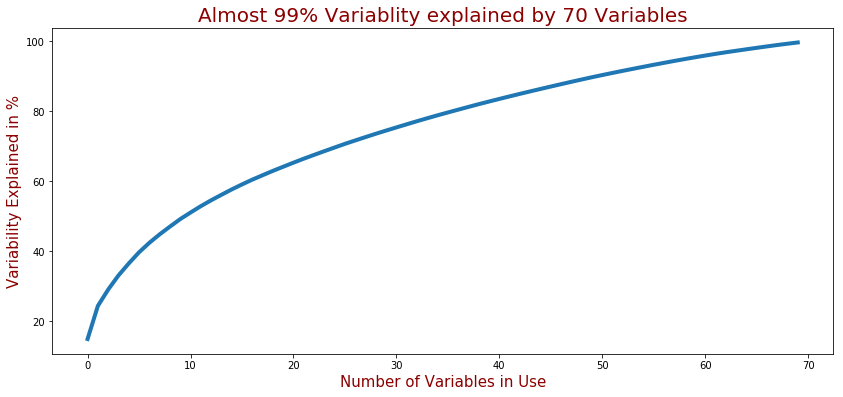

In [10]:
import warnings
warnings.filterwarnings("ignore")

start_time = time.time()
# Normalizing the full dataframe
new = pd.concat([df2,test2],axis=0)
standard = StandardScaler()
result = standard.fit_transform(new.iloc[:,0:new.shape[1]])
result = pd.DataFrame(result)

# PCA calculation
pca = PCA(n_components=70)
principal_comp = pca.fit_transform(result)
pca_time = time.time()-start_time


principal_comp = pd.DataFrame(principal_comp)
explanation = pca.explained_variance_ratio_
cummulative_sum = explanation.cumsum()

print("Time to compute PCA {}".format(pca_time))


plt.figure(figsize=(14,6))
plt.plot(cummulative_sum*100,linewidth=4)
plt.xlabel("Number of Variables in Use",size=15,color="darkred")
plt.ylabel("Variability Explained in %",size=15,color="darkred")
plt.title("Almost 99% Variablity explained by 70 Variables",size=20,color="darkred")




In [11]:
y_col = pd.concat([df2.cancer_type,test2.cancer_type],axis=0)
principal_comp = pd.DataFrame(principal_comp)
principal_comp = pd.concat([principal_comp,y_col.reset_index()],axis=1).drop("index",axis=1)
train_x,test_x,train_y,test_y = train_test_split(principal_comp.iloc[:,0:principal_comp.shape[1]],principal_comp.cancer_type,test_size=0.25)

In [12]:
# SVM model after PCA
com_time_laps=[]
for i in range(100):
    start_time = time.time()
    clf2 = svm.SVC()
    clf2.fit(train_x,train_y)
    accuracy = accuracy_score(clf2.predict(test_x),test_y) * 100
    accuracy=round(accuracy)
    time_laps_after_pca = time.time() - start_time
    com_time_laps.append(time_laps_after_pca)
print("The accuracy is {} and computaiton time is {} \nNeeds Improvement in accuracy".format(accuracy,np.mean(com_time_laps)))
lis = [accuracy,np.mean(com_time_laps)]

The accuracy is 67.0 and computaiton time is 0.0017555880546569825 
Needs Improvement in accuracy


In [13]:
#Total change in computaion time
x = ((avg_time_laps-time_laps_after_pca )/avg_time_laps ) *100
print("Overall Improvement in computation of SVM is: \x1b[1;31m {} \x1b[0m ".format(round(x)))


Overall Improvement in computation of SVM is:  94.0  


In [14]:
train_x.head()

,0,1,2,3,4,5,6,7,8,9,...,61,62,63,64,65,66,67,68,69,cancer_type
26,42.796952,-29.420715,-29.103852,-27.604305,22.628411,14.380874,14.843379,-29.247426,-17.901182,-30.971366,...,-1.953567,1.663448,0.242123,1.278664,0.033604,0.611402,0.068486,-0.068609,-1.850865,0
66,-11.714133,55.698681,3.546751,5.928988,8.009634,15.955642,10.099984,-3.194068,-14.406912,-8.406453,...,3.453057,-0.157839,-0.503231,-0.974063,2.683368,0.766641,-2.928373,-0.427735,-0.659051,0
25,6.656666,32.233189,-12.834615,4.700881,-14.959215,-5.643987,-7.441727,4.320630,-1.058720,7.641891,...,9.570597,3.356945,1.910671,-1.471609,5.429517,-2.190031,-4.991958,0.241874,0.987664,0
63,3.056868,-25.400509,19.520207,0.774643,-4.171898,2.847128,10.537458,-2.849937,-0.290435,-2.692992,...,0.021263,3.153535,-4.595020,-7.344072,-6.088834,3.497443,1.442103,1.554007,-1.075379,1
7,77.372428,56.088813,-11.467009,-1.292284,46.817098,49.740072,30.516873,-23.876683,43.631893,29.742762,...,0.443887,1.312935,0.375082,-0.015131,0.213277,0.190173,-0.564389,0.238221,0.472160,0


In [15]:
start_time = time.time()
nv2 = GaussianNB()
nv2.fit(train_x.iloc[:,0:train_x.shape[1]-1],train_y)
time_laps = time.time()-start_time
a = accuracy_score(nv2.predict(test_x.iloc[:,0:test_x.shape[1]-1]),test_y)*100
naive_bayse = round(a)

lis2=[naive_bayse,time_laps]

In [16]:
cross_tab = pd.DataFrame(lis,lis2)
cross_tab.reset_index(inplace=True)
cross_tab.columns=("Naive Bayes","SVM")
cross_tab.index=("Accuracy","Computation time")
print("    Metric with 72 columns")
cross_tab

    Metric with 72 columns


,Naive Bayes,SVM
Accuracy,61.000000,67.000000
Computation time,0.001998,0.001756


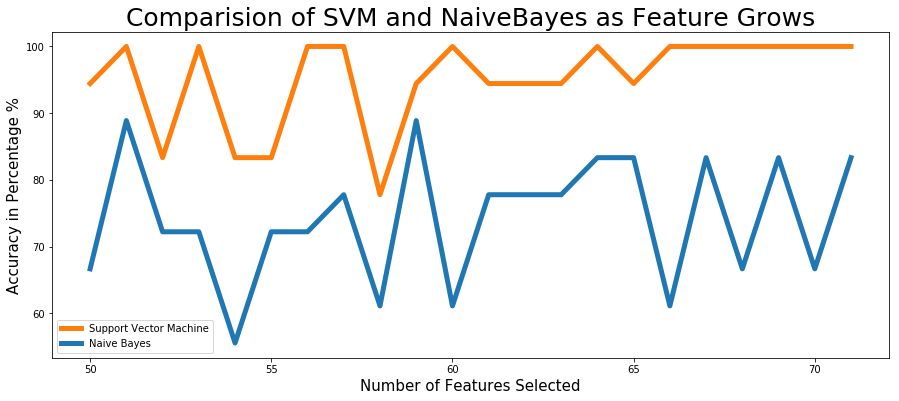

In [17]:
acc = []
acc_nb = []
for i in range(50,72):
    pca = PCA(n_components=i)
    principal_comp = pca.fit_transform(result)
    principal_comp = pd.DataFrame(principal_comp)
    y_col = pd.concat([df2.cancer_type,test2.cancer_type],axis=0)
    principal_comp = pd.DataFrame(principal_comp)
    principal_comp = pd.concat([principal_comp,y_col.reset_index()],axis=1).drop("index",axis=1)

    #SVM
    train_x,test_x,train_y,test_y = train_test_split(principal_comp.iloc[:,0:(principal_comp.shape[1]-1)],principal_comp.cancer_type,test_size=0.25)
    
    clf2 = svm.SVC(kernel='linear',gamma="auto",C=0.001)
    clf2.fit(train_x,train_y)
    a = accuracy_score(clf2.predict(test_x),test_y) * 100
    
    #NB
    nv2 = GaussianNB()
    nv2.fit(train_x,train_y)
    b = accuracy_score(nv2.predict(test_x),test_y) *100
    
    acc.append(a)
    acc_nb.append(b)
    
    
plt.figure(figsize=(15,6))
plt.plot(range(50,72),acc,'#ff7f0e',range(50,72),acc_nb,'#1f77b4',linewidth=5)
plt.legend(["Support Vector Machine","Naive Bayes"],loc="best")
plt.xlabel("Number of Features Selected",size=15)
plt.ylabel("Accuracy in Percentage %",size=15)
plt.title("Comparision of SVM and NaiveBayes as Feature Grows",size=25)
plt.style.use("bmh")

In [22]:
#hyper parameter at var=72
kernel=["linear","poly","rbf","sigmoid"]
cost = [.001,.01,.1,1,10,100,1000]

m = []

for k in kernel:
    ker = k
    for c in cost:
        cos = c
        accu=[]
        
        for i in range(10):
            clf2 = svm.SVC(kernel=ker,gamma="auto",C=cos)
            clf2.fit(train_x,train_y)
            a = accuracy_score(clf2.predict(test_x),test_y) * 100
            accu.append(a)
            
        means = np.mean(accu)
        m.append(means)     
        print(" {} kernel,  penalty = {}, accuacy = {} ".format(k,c,round(means)))
        time.sleep(.3)

 linear kernel,  penalty = 0.001, accuacy = 100.0 
 linear kernel,  penalty = 0.01, accuacy = 100.0 
 linear kernel,  penalty = 0.1, accuacy = 100.0 
 linear kernel,  penalty = 1, accuacy = 100.0 
 linear kernel,  penalty = 10, accuacy = 100.0 
 linear kernel,  penalty = 100, accuacy = 100.0 
 linear kernel,  penalty = 1000, accuacy = 100.0 
 poly kernel,  penalty = 0.001, accuacy = 56.0 
 poly kernel,  penalty = 0.01, accuacy = 56.0 
 poly kernel,  penalty = 0.1, accuacy = 56.0 
 poly kernel,  penalty = 1, accuacy = 56.0 
 poly kernel,  penalty = 10, accuacy = 56.0 
 poly kernel,  penalty = 100, accuacy = 56.0 
 poly kernel,  penalty = 1000, accuacy = 56.0 
 rbf kernel,  penalty = 0.001, accuacy = 56.0 
 rbf kernel,  penalty = 0.01, accuacy = 56.0 
 rbf kernel,  penalty = 0.1, accuacy = 56.0 
 rbf kernel,  penalty = 1, accuacy = 56.0 
 rbf kernel,  penalty = 10, accuacy = 56.0 
 rbf kernel,  penalty = 100, accuacy = 56.0 
 rbf kernel,  penalty = 1000, accuacy = 56.0 
 sigmoid kernel, 